# Social Computing/Social Gaming - Summer 2021
# Exercise Sheet 5 - Hate Speech
Online hate speech is a large scale phenomenon that gained more and more traction in modern society in recent years. Violence attributed to online hate speech has increased worldwide. The same technology that allows social media to galvanize activist movements and NGOs can be used by hate/crime groups seeking to organize and recruit. It also allows conspiration theorists to reach audiences far broader than their core community. It is time – now more than ever –  to put systems in place that make sure social media is not used as a tool to conduct criminal activities. Fortunately, modern technology allows us to do just that.

In this exercise sheet, we will attempt to accurately and automatically detect two instances of hate speech in Twitter: sexism and racism. The first step in this process will be to prepare the data before it is fed to the model. We do this with the help of the Universal Sentence Encoder, which is explained in more detail later. Additionally, we also need to encode the labels and split the data.

We then take two different approaches in classifying the data. In other words, we will create, train, evaluate and compare two models. One of them is purely based on text (the Base Model) and the other also takes the social context of the users into account (the Social Model).

## Why Twitter?
Hate crimes are communicative acts, often provoked by events that incite retribution in a targeted group. The continued growth of online social networks and micro-blogging Web services, such as Twitter, enable an extensive and near real-time data source through which the analysis of hateful and antagonistic responses to “trigger” events can be undertaken. Such data affords researchers with the possibility to measure the online social mood and emotion following large-scale, disruptive, and emotive events. Twitter is a defensible and logical source of data for such analysis given that users of social media are more likely to express emotional content due to deindividuation (anonymity, lack of self-awareness in groups, disinhibition) [1].

## Task 5.0: The Data
For this, we have picked the dataset of Waseem and Hovy [2], in a slightly modified version. The collection originally contained 16,914 labeled tweets, however some of them are not accessible via Twitter API anymore. As a consequence, the dataset now contains 16,849 tweets divided in the following categories: 3,378 *sexism*, 1,970 *racism* and 11,501 *neither*.

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Reads the data set from a .csv file
data = pd.read_csv('tweets.csv', low_memory=False)
data = data.astype(str)

# This drop operation is necessary because of an inconsistency in the dataset
data = data.drop([3343, 3344])
data = data[['text', 'label']]

# We need to do a unique and precise reordering to match with graph information later on
unique_tweets, indices = np.unique(data['text'].to_numpy(), return_index=True)
ordered_labels = data['label'].to_numpy()[indices]
data = pd.DataFrame(np.stack((unique_tweets, ordered_labels), axis=1), columns=['text', 'label'])

In [3]:
# See the summary of the dataset's content

print("TOTAL TWEETS: {}, RACIST: {}, SEXIST: {}, NEITHER: {}".\
      format(len(data), len(data[data["label"] == 'racism']), len(data[data["label"] == 'sexism']), len(data[data['label'] == 'none'])))

TOTAL TWEETS: 16849, RACIST: 1970, SEXIST: 3378, NEITHER: 11501


## Task 5.1: Preprocessing

### a) Encode the labels
In order for [PyTorch](https://pytorch.org) to work with the labels, they need to have a specific format. Strings need to be replaced by numbers with an according mapping.

Map the labels from the `label_mapping = ['sexism' 'none' 'racism']` to a numeric vector.

In [4]:
from sklearn.preprocessing import LabelBinarizer

In [5]:
# Extract labels from dataset
lb = LabelBinarizer()
labels = np.array(data["label"].tolist())

# TODO: Encode labels as binary One Hot vectors
# Hint: First map the labels to integer then binarize them

# Mapping labels to integer
label_mapping = ['sexism', 'none','racism']
lb.fit(label_mapping)
factorized_labels = lb.transform(labels)

    
# Shows the actual shape of the labels
print(labels.shape)
print(label_mapping)
print(labels)
print(factorized_labels)

(16849,)
['sexism', 'none', 'racism']
['sexism' 'none' 'none' ... 'none' 'none' 'none']
[[0 0 1]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]


### b) Universal Sentence Encoder
Google's Universal Sentence Encoder ([USE](https://tfhub.dev/google/universal-sentence-encoder/4) [4]) is a convenient way to map any type of sentence to a 512-dimensional vector. In these 512-dimensional vectors semantic meaning is encoded.

In [6]:
import tensorflow_hub as hub

# Run this code block only once as the download will take some time and embedding is very memory expensive!
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In this task you are suppossed to get a feeling for this type of embedding. Find a pair of sentences that are similar in their meaning but not syntactically. After that, think of two semantically very different sentences.
Obtain the values for them and compare them.

**TODO: Write your observations here**

The embeddings for two identical sentences had the total difference of zero. And for sentences that are similar in their meaning but not syntactically (the first pair) the acummulated difference was smaller than for two semantically very different sentences (the second pair).

In [7]:
# Try out USE here
embeddings = embed([
    "My sister likes cats.",
    "My female sibling enjoys the company of felines.",
    "The sound of raindrops drives me insane!",
    "Do peaches grow at the bottom of the ocean?"])

print(embeddings)
acum1 = 0
acum2 = 0

for i in range(512):
    diff_sim = abs(embeddings[0][i]-embeddings[1][i])
    diff_dif = abs(embeddings[2][i]-embeddings[3][i])
    acum1+=diff_sim
    acum2+=diff_dif
    
print("Total difference in the 'similar' sentences:",acum1 )
print("Total difference in the 'different' sentences:",acum2 )

tf.Tensor(
[[ 0.02770652 -0.02446998 -0.01478388 ... -0.03572233 -0.00076744
  -0.01162829]
 [ 0.05293113 -0.04229148 -0.03967517 ... -0.00483392  0.03231505
   0.00967237]
 [ 0.06448624  0.01319296  0.06360155 ...  0.01493153  0.05566809
   0.06355267]
 [ 0.00565269  0.05031515  0.01090292 ... -0.04254122  0.00633443
  -0.00829858]], shape=(4, 512), dtype=float32)
Total difference in the 'similar' sentences: tf.Tensor(13.584189, shape=(), dtype=float32)
Total difference in the 'different' sentences: tf.Tensor(25.727364, shape=(), dtype=float32)


In [8]:
# TODO: Now encode our dataset's tweets

encoded_tweets = embed(data['text'])
print(encoded_tweets)
print(factorized_labels.shape[0])

tf.Tensor(
[[ 0.01578292 -0.02893438  0.04538639 ...  0.03280301 -0.02938721
  -0.06488362]
 [ 0.01988203 -0.00856351 -0.05807869 ... -0.00276093 -0.01231047
   0.03998613]
 [-0.01607793 -0.02702751  0.08541911 ... -0.00899439 -0.05160175
  -0.07524079]
 ...
 [ 0.06784236 -0.00554431  0.08238138 ...  0.04196434 -0.04107929
  -0.068078  ]
 [-0.0115056  -0.01822575 -0.0158698  ... -0.02492372  0.03026116
  -0.05059727]
 [ 0.0311044  -0.03215659  0.0460307  ... -0.03171749  0.01963099
  -0.04515303]], shape=(16849, 512), dtype=float32)
16849


## Task 5.2: Base Model

### a) Base Model creation
In this code we create our base model and train it afterwards using the PyTorch library. We use a simple Neural Network to build this model. You can read about Neural Networks here in case you are not familiar with them.
You can get a basic intuition for Neural Networks [here](https://medium.com/@shaistha24/basic-concepts-you-should-know-before-starting-with-the-neural-networks-nn-3-6db79028e56d) [5].

For the base model we have our 512 dimensional input layer. Then we have a fully connected layer with 100 nodes and with a dropout rate of 0.5 is added. For now, you do not need to know what dropout is. After the dropout, another fully connected layer with 50 nodes is added and we once again add a 0.5 dropout rate.
Our output layer has 3 nodes: One for "sexism", "none" and "racism". The computed values for these last 3 nodes correspond to the probability of belonging to either one of our categories.

![title](img/base_model.png)

In [92]:
import torch
import torch.nn as nn
import torch.optim as optim

BATCH_SIZE = 32
ENCODING_DIM = 512

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(ENCODING_DIM, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(50, 3)

    def forward(self, x):
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x

model = MyModel()

# Define the loss and optimizer with according parameters

# Check the internet to unterstand what impact the learning rate (lr) has!

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


In [93]:
from torchsummary import summary
summary(model, input_size = (0,512), batch_size = 32, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [32, 0, 100]          51,300
           Dropout-2               [32, 0, 100]               0
            Linear-3                [32, 0, 50]           5,050
           Dropout-4                [32, 0, 50]               0
            Linear-5                 [32, 0, 3]             153
Total params: 56,503
Trainable params: 56,503
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.22
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


### b) Train-Test split for Base Model
Splitting our labeled data into a train test and validation set is a common practice.
* Train set: This set is used to train our model on. The model will try to learn from it.
* Validation set: This set is used to choose hyper parameters. Since creating good models requires to find the right parameters (e.g. what kind of activation function, how many epochs etc.) this set is used to maximize the performance of a model for a fixed choice of parameters.
* Test set: This set is used to evaluate our final model on. After the model has been trained and a final decision for hyper parameters has been made, the model will be evaluated on this set only. No more parameters should be changed after that.

This rather strange seeming approach helps to identify models that actually generalize well and not just perform very good because we adapted the parameters to maximize the performance on one particular set.

We will use 60% of our dataset to train our model (the train set) and the remaining 20% to evaluate our model (the test set).

**Hint:** The sklearn library offers a function that could help you out with this task.

In [94]:
from sklearn.model_selection import train_test_split

# TODO: Split tweets and labels in Train/Test/Validation 60/20/20

#splitting for training and testing
X_train, X_test, y_train, y_test = train_test_split(encoded_tweets.numpy(), factorized_labels, test_size=0.2, random_state=1)
#splitting for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print("Training data shape: {}, Labels shape: {}".format(X_train.shape, y_train.shape))
print("Test data shape: {}, Labels shape: {}".format(X_test.shape, y_test.shape))
print("Validation data shape: {}, Labels shape: {}".format(X_val.shape, y_val.shape))

Training data shape: (10109, 512), Labels shape: (10109, 3)
Test data shape: (3370, 512), Labels shape: (3370, 3)
Validation data shape: (3370, 512), Labels shape: (3370, 3)


In order to feed the data into the model, we must create Dataset objects for it, allowing the creation of Dataloaders. The Dataset retrieves both the features and labels of the data. While training a model, we want to feed the data in batches and reshuffle it at every epoch to reduce model overfitting. Dataloaders offer an API to do that process.

In [95]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# TODO: Create a CustomDataset class for our Tweet data

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        return x, y

# Create the Datasets
train_dataset = CustomDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = CustomDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
test_dataset = CustomDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

# DataLoader for batching and parallel data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### c) Train the Base Model

**1.** Train the model.

In [99]:
num_epochs = 50

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    train_loss = 0
    train_steps = 0

    val_loss = 0
    val_acc = 0
    val_steps = 0

    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_steps += 1

    model.eval()
    with torch.no_grad():
      for inputs, labels in val_loader:
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate validation accuracy
        _, val_labels = torch.max(outputs, dim=0)
        val_acc += (val_labels == labels).sum().item() / labels.size(0)

        val_steps += 1

    train_loss_history.append(train_loss/train_steps)
    val_loss_history.append(val_loss/val_steps)
    val_accuracy_history.append(val_acc/val_steps)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss={train_loss/train_steps}, validation loss={val_loss/val_steps}, validation accuracy={val_acc/val_steps}')

Epoch 1/50
Training loss=0.08548366431076126, validation loss=0.10944035536838027, validation accuracy=0.08502358490566037
Epoch 2/50
Training loss=0.0856976793324457, validation loss=0.09569379139058995, validation accuracy=0.06880896226415094
Epoch 3/50
Training loss=0.08430263246232762, validation loss=0.09392166942498593, validation accuracy=0.08962264150943396
Epoch 4/50
Training loss=0.08503719916142806, validation loss=0.10120936272279271, validation accuracy=0.10170990566037735
Epoch 5/50
Training loss=0.0835945549085029, validation loss=0.09589584442382713, validation accuracy=0.07045990566037735
Epoch 6/50
Training loss=0.08519598168521365, validation loss=0.09989569926599287, validation accuracy=0.08077830188679246
Epoch 7/50
Training loss=0.08316599894197116, validation loss=0.09258778312436815, validation accuracy=0.06456367924528301
Epoch 8/50
Training loss=0.08194025943668772, validation loss=0.09228301136139429, validation accuracy=0.06780660377358491
Epoch 9/50
Trainin

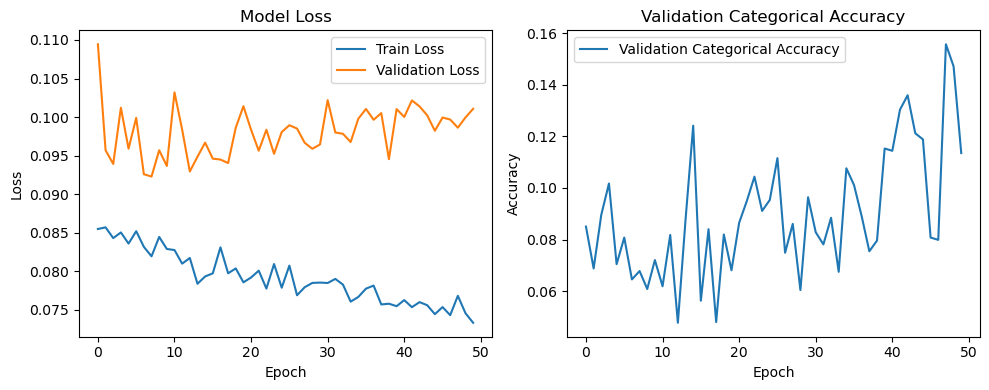

In [100]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation categorical accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation Categorical Accuracy')
plt.title('Validation Categorical Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**2.** After you have looked at the graph, what do you think is an appropriate amount of `epochs`? Briefly explain at which amount of epochs the model seems to be underfitting or overfitting and how this depends on the learning rate?

**TODO: Write your observations here**

Too big of a learning rate makes for 'large' jumps -- might miss the optimum. Too small -- takes too long to converge. Here, the base ~20 epochs was enough with the initial learning rate. Usually early stopping is implemented when training loss still goes down but validation loss is starting to increase (overfitting). With the current learning rate this looks like it's underfitting the whole way through.

### d) Evaluate the Base Model

The F1 score is a universal measurement of a test's accuracy. It is calculated as the harmonic mean of *precision* and *recall*.

- **precision** refers to the number of true positives divided by the number of all positives
- **recall** refers to the number of true positives divided by the number of relevant elements


$$F_{1} = \frac{2}{recall^{-1} + precision^{-1}} = \frac{tp}{tp+\frac{1}{2}(fp+fn)}$$

where
*   tp = true positives
*   fp = false positives
*   fn = false negatives

**1.** Why would we prefer the F1 Score over only the precision?

**2.** Evaluate the text model with an F1 score.

**TODO 1: Write your explanation here**


In [130]:
#from src.evaluation import f1_score_overall
from src.evaluation import f1_score_overall
%load_ext autoreload
%autoreload 2

In [131]:
# Predicting the labels from the test set
with torch.no_grad():
    y_pred = model(torch.tensor(test_dataset.encodings))

  y_pred = model(torch.tensor(test_dataset.encodings))

W0702 11:02:04.555523 38316 warnings.py:109] C:\Users\blody\AppData\Local\Temp\ipykernel_38316\3257305534.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_pred = model(torch.tensor(test_dataset.encodings))



In [158]:
# TODO 2: Evaluate text model
# Hint: You can lookup the evaluation.py in the src folder for documentation
print(y_pred)
print(y_test)

print(lb)
f1_score_overall(y_test, y_pred, lb, label_mapping=label_mapping,only_overall=False)

tensor([[0.9427, 0.0096, 0.0423],
        [0.9271, 0.0114, 0.0575],
        [0.9112, 0.0132, 0.0731],
        ...,
        [0.9744, 0.0060, 0.0114],
        [0.9765, 0.0058, 0.0093],
        [0.9156, 0.0127, 0.0688]])
[[1 0 0]
 [1 0 0]
 [1 0 0]
 ...
 [1 0 0]
 [1 0 0]
 [1 0 0]]
LabelBinarizer()
F1 Scores:
 sexism: 0.8731658291457287
 none: 0.7032640949554896
 racism: 0.5866177818515124
 Overall: 0.7969186347718966


## Task 5.3: Preprocessing for Social Model
Now that we have evaluated our base model we can try to enhance it by using some sort of a social context. To do so, we are using our base model's prediction to compute an average hate score for each of the followers of an author. This means that for each author we take all his follower's tweets and predict the label. We then take the average of each prediction which results in our average hate score.

For each tweet we then not only feed in the tweet itself, but also the hate score.

### Load adjacency matrix for users

In order to create our social model, we first need to load the adjacency matrix. This matrix represents the follower network between all users that have written the 16849 tweets (crawled by Linda Jahn [6]). You can check the `extend_data.ipynb` file to find out how the adjacency matrix was created.

The 16849 tweets were written by 2031 distinct users. This results in a 2031x2031 matrix.

In [159]:
# Load users adjacency matrix
users_adjacency_matrix = np.load("pickle_files/users_data/users_adjacency_matrix.npy")

### a) Graph visualization & manipulation
Now we are going to plot the previously loaded adjacency matrix. Since we are going to feed the matrix to the Neural Network later, and because the user network is just a tiny subset of the whole Twitter network it is important to check if the network contains any useful information.


**1.** Plot the graph corresponding to the given adjacency matrix.
**Note:** For better visualization, the nodes are color-coded based on their degree.

In [160]:
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

Total number of nodes: 2031


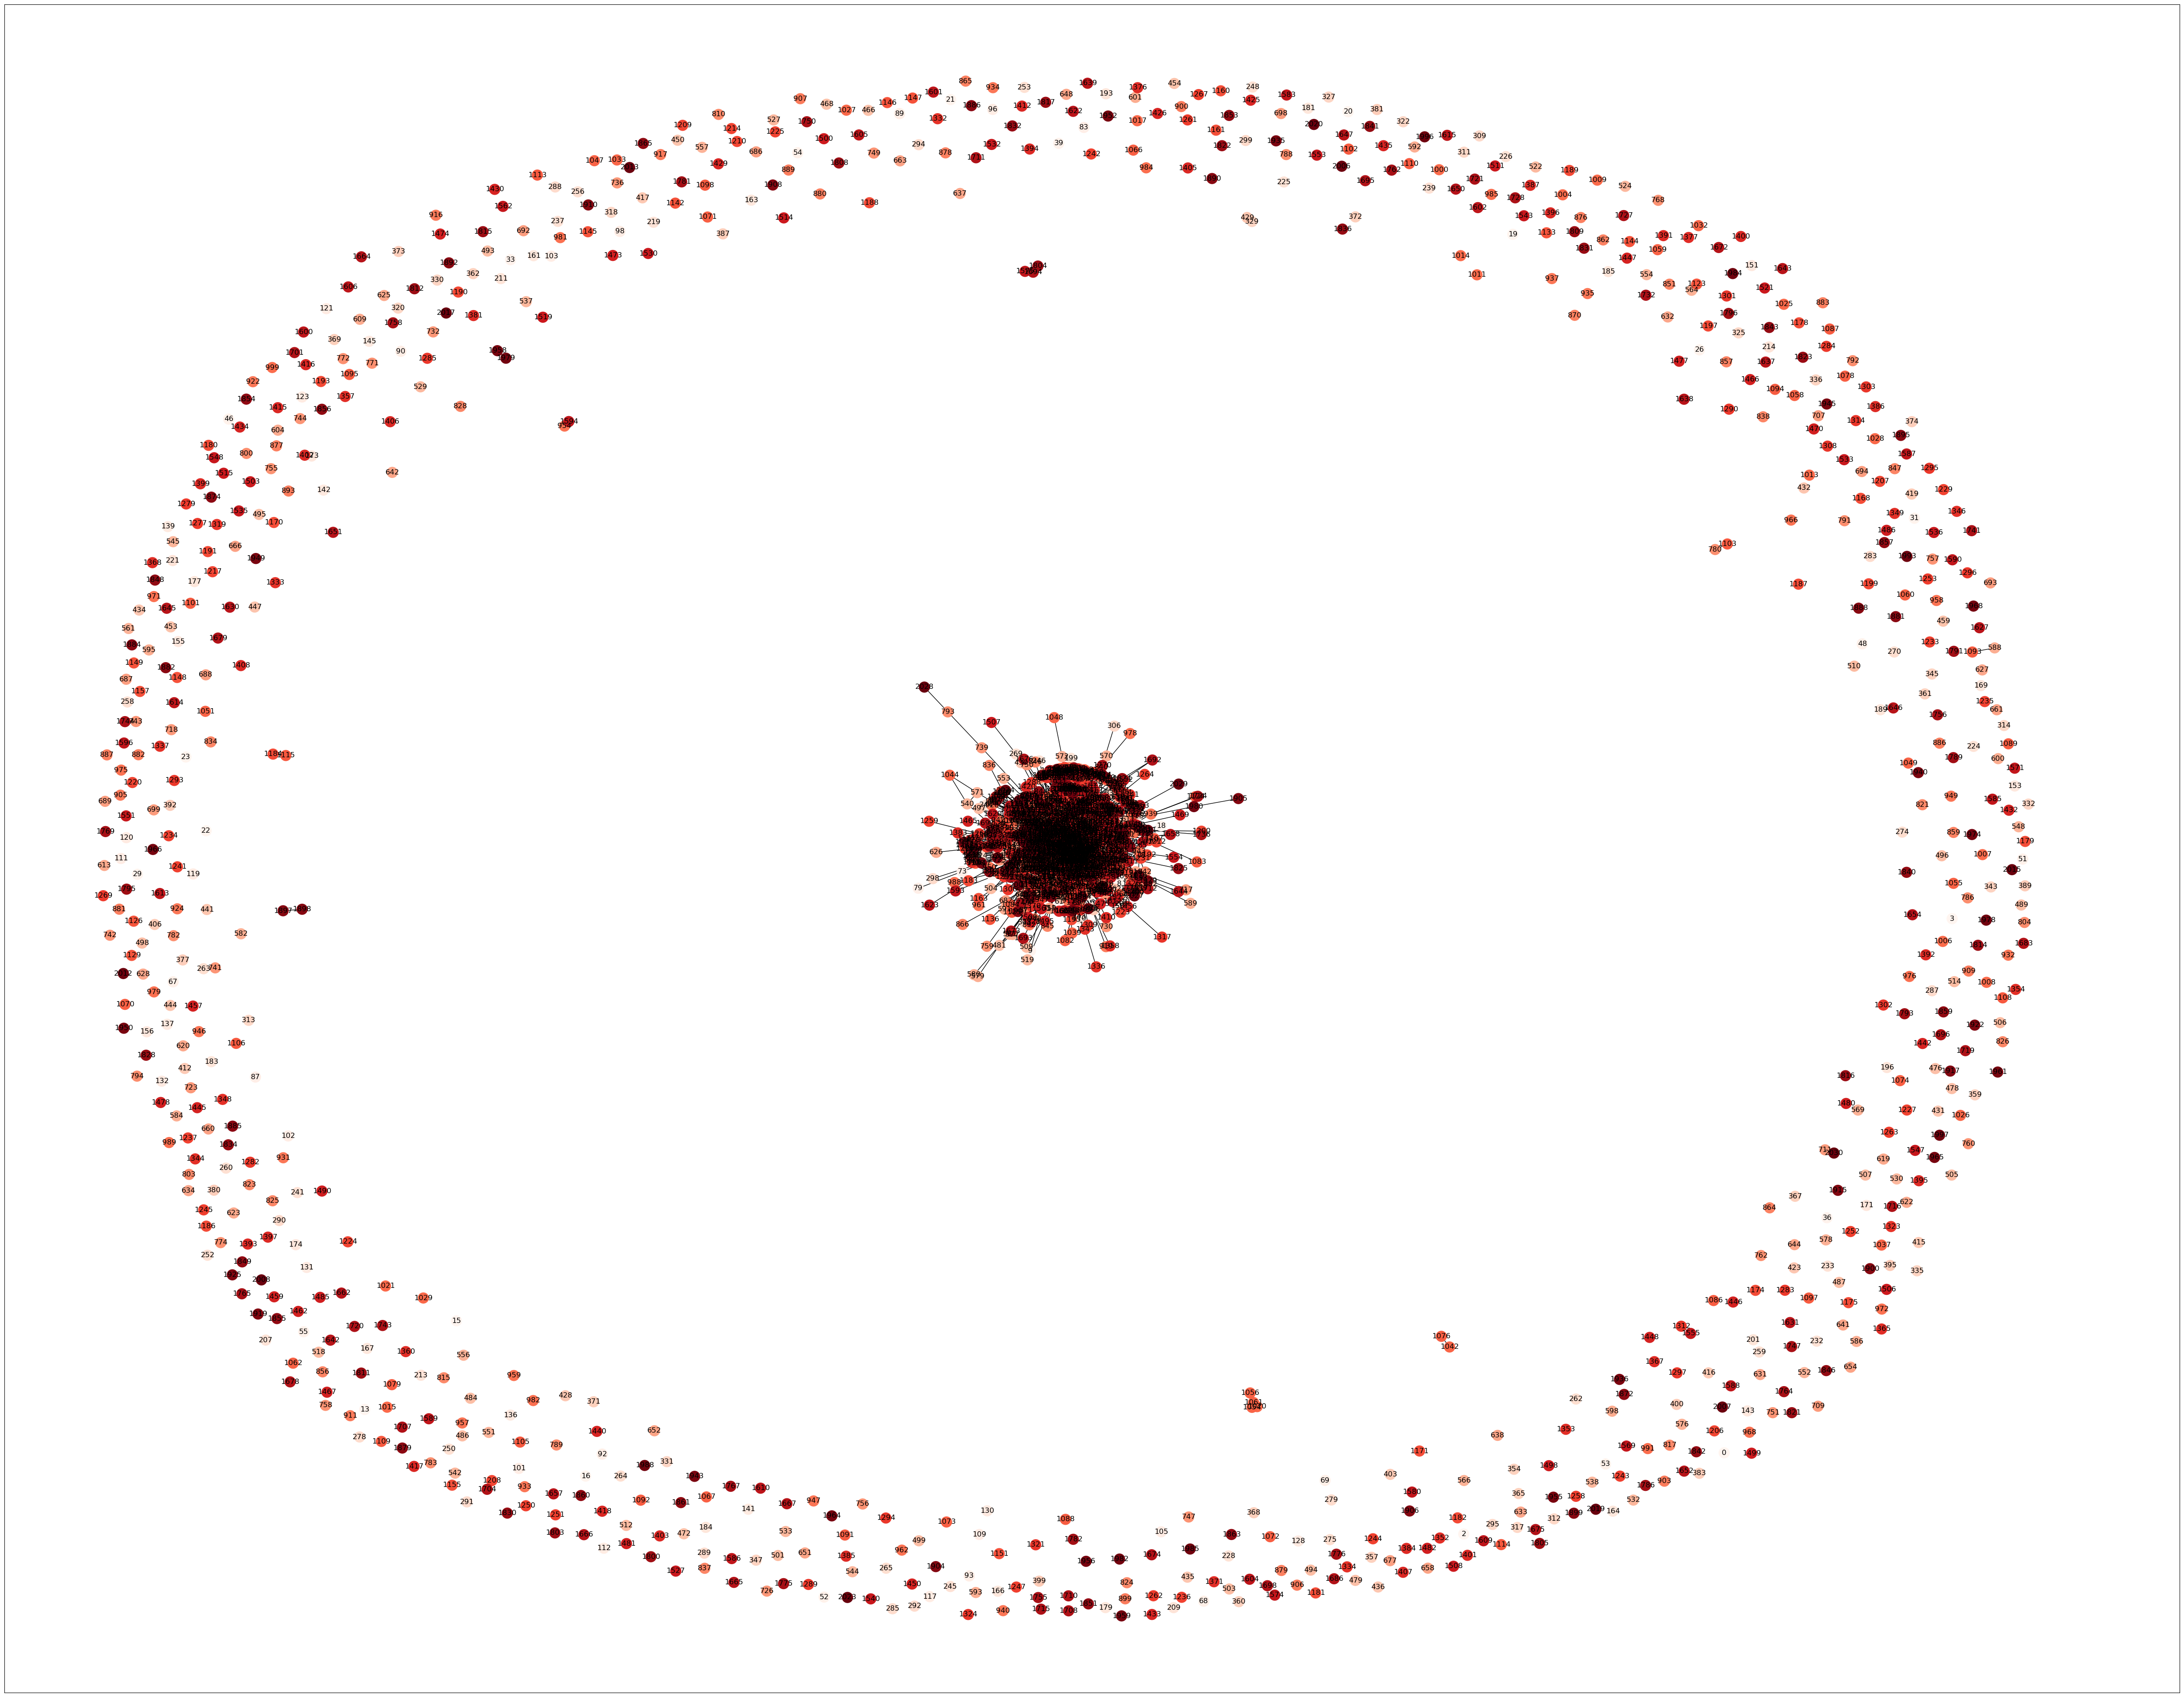

In [165]:
def show_graph(users_adjacency_matrix):

    # TODO 1:

    graph=nx.from_numpy_matrix(users_adjacency_matrix)

    print("Total number of nodes:", nx.number_of_nodes(graph))

    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw_networkx(graph,
            node_size=300,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()


show_graph(users_adjacency_matrix)

**2.** Briefly describe the graph. How many communities do you think it depicts?

**TODO 2: Write your observations here**

The graph above looks like it depicts one community and a number of disconnected nodes.

**3.** Now let us try to actually calculate the number of communities within this graph. First, get rid of the uninteresting nodes that have zero or very few edges and just inspect the "core" graph. Expand on the code that you have written in the exercise above.
**Hint**: You can do this by excluding all nodes with an `nx.eigenvector_centrality()` lower than $10^{-8}$.

Total number of nodes: 2031
Total number of significant nodes: 1176


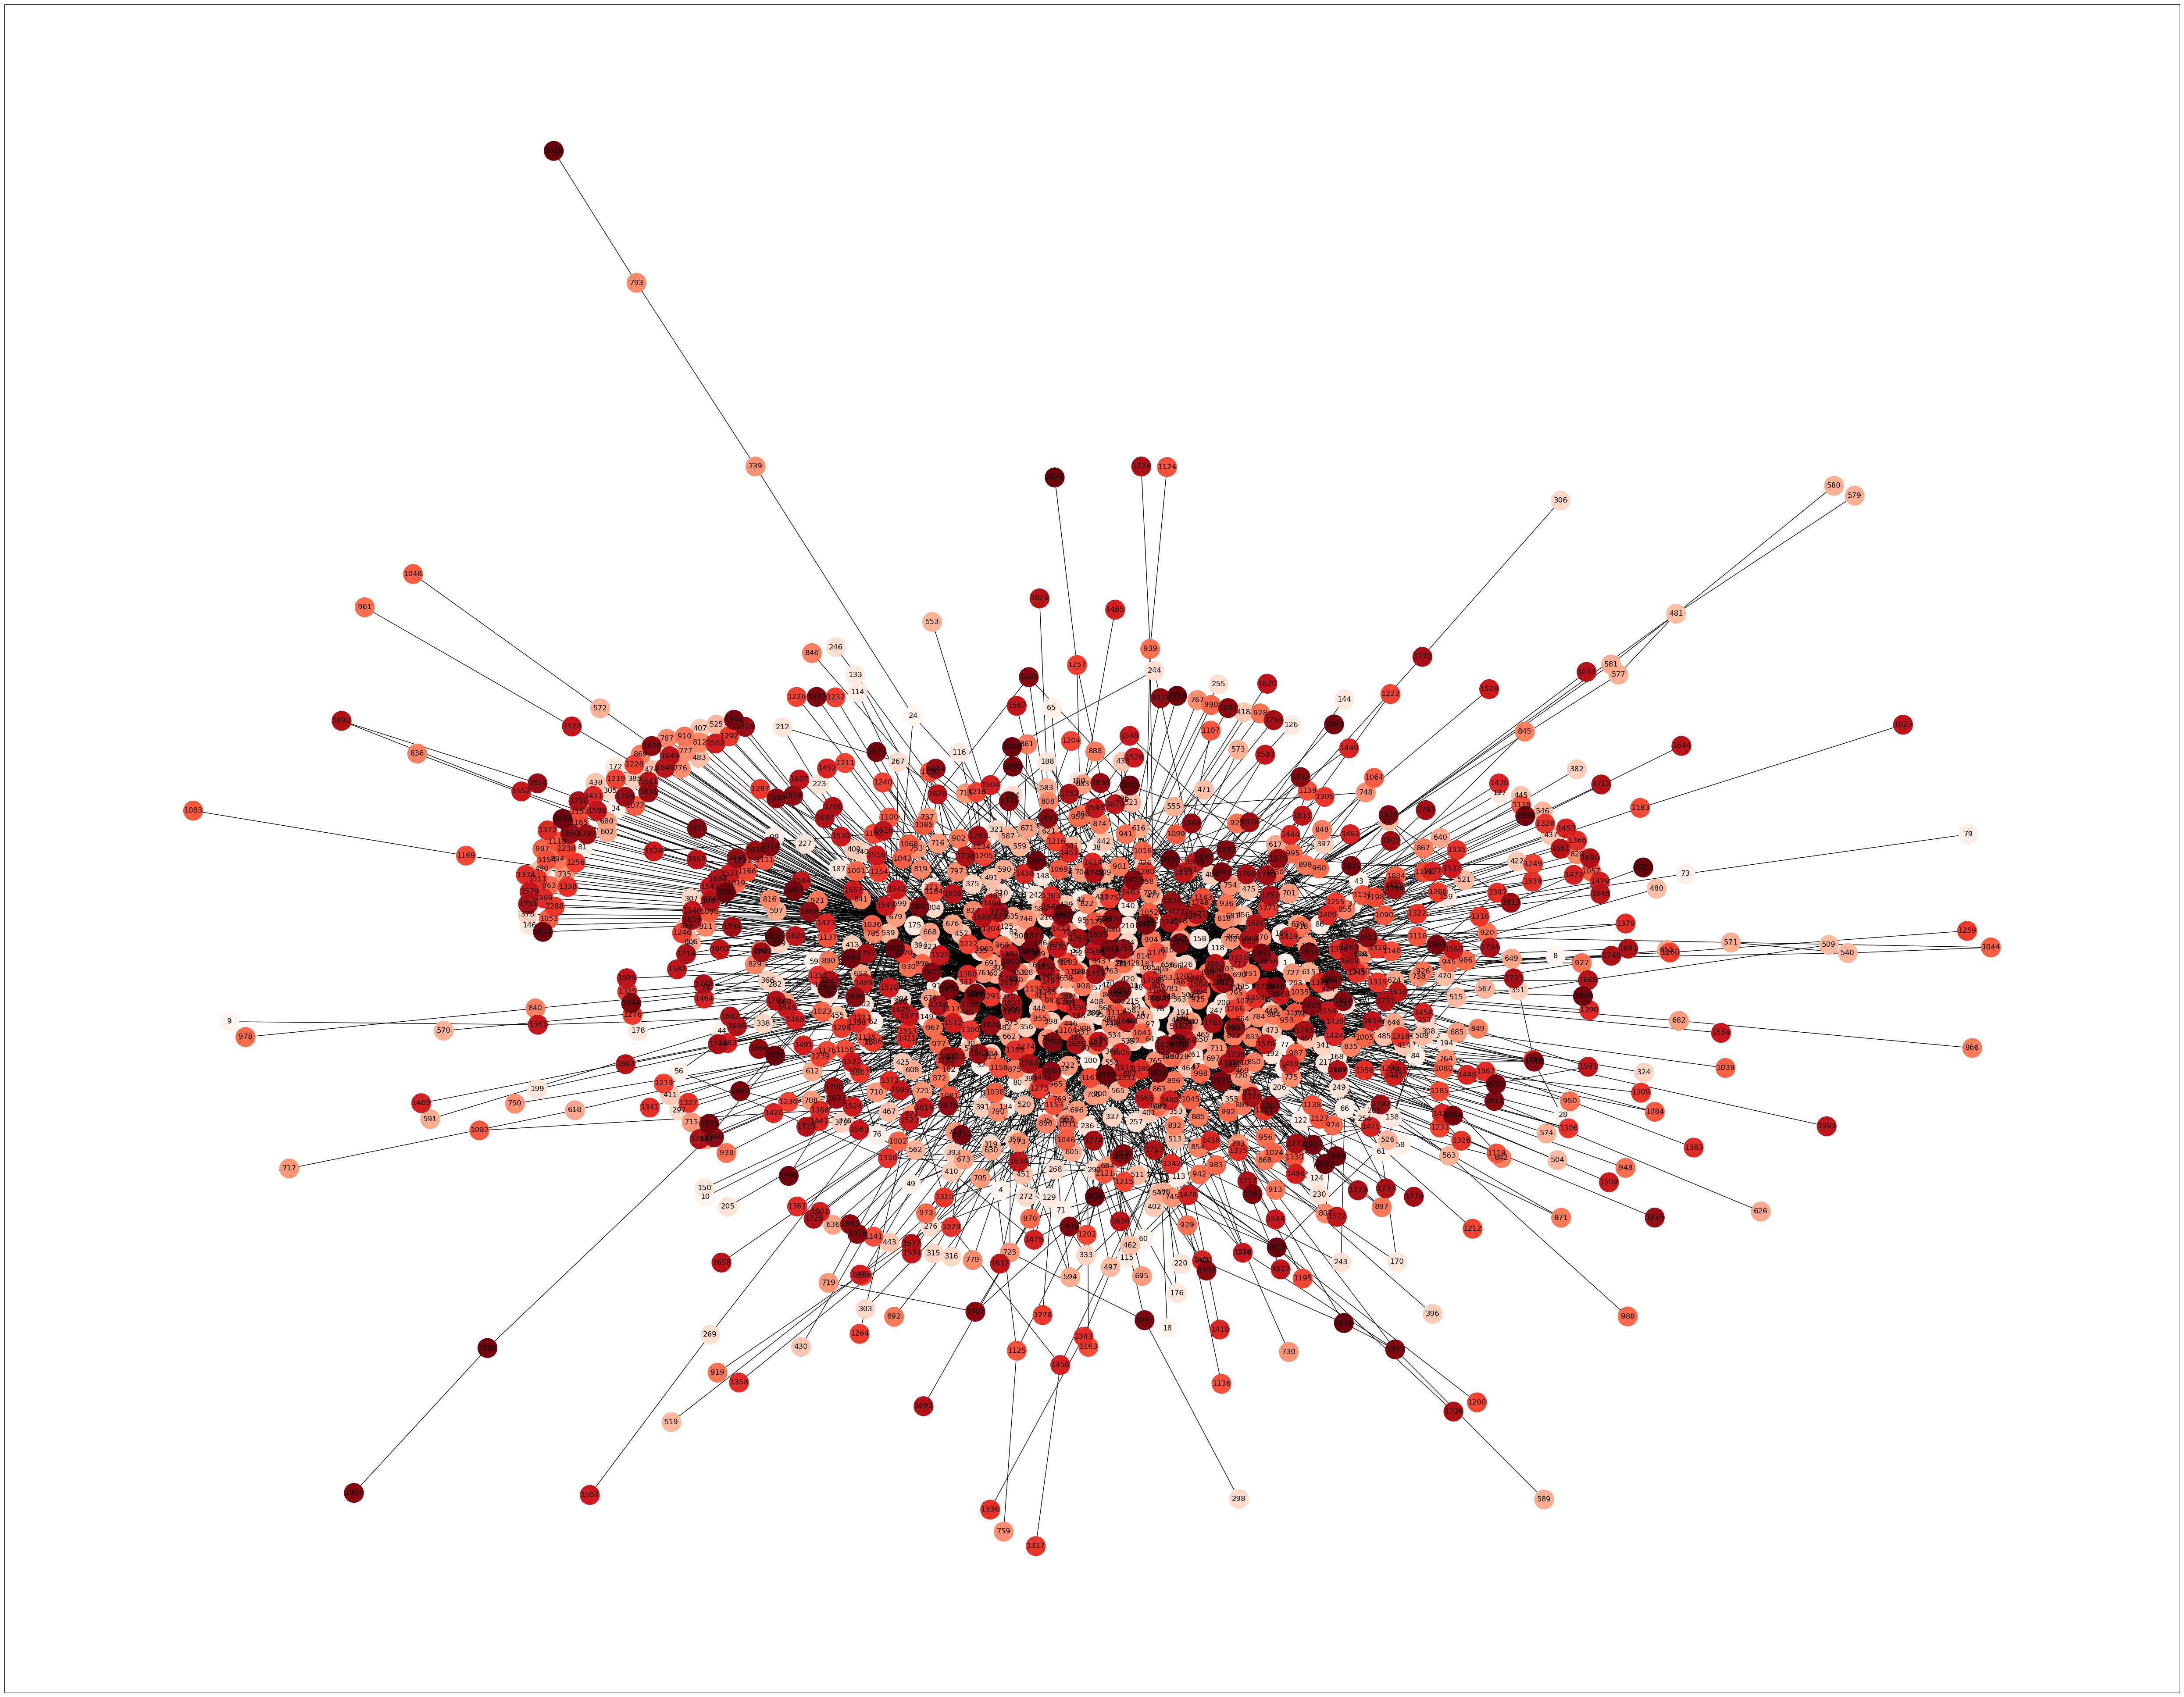

In [215]:
# TODO 3:

graph=nx.from_numpy_matrix(users_adjacency_matrix)


print("Total number of nodes:", nx.number_of_nodes(graph))
centrality = nx.eigenvector_centrality(graph) 
for node in range(len(graph.nodes)):
    if centrality[node] < 1e-8:
        graph.remove_node(node)

print("Total number of significant nodes:", nx.number_of_nodes(graph))

def show_graph_core(users_adjacency_matrix, graph):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(64, 50), dpi=100)
    nx.draw_networkx(graph,
            node_size=1000,
            node_color=range(nx.number_of_nodes(graph)),
            cmap=plt.cm.Reds,
            pos=nx.spring_layout(graph)
           )
    plt.show()


show_graph_core(users_adjacency_matrix, graph)

**4.** Do you think the social context could further improve our hate speech detection model? Find at least 2 pros and 2 cons.

**TODO 4: Write your observations here**

Yes, I think it could, for the following reasons (pros):
* people with more 'hateful' followings are more likely to be hateful themselves
* increased explainability

However, there are also downsides (cons):
* point one of the pros not necessarily true
* lack of context for short posts
* difficulty in interpretation -- irony/sarcasm/etc

### b) Employment of our Base Model to predict the hatefulness of an author's followers

Now that we have a trained model, we can use it to predict the hatefulness for any tweet. Therefore, we can use it to predict an average hate score for each follower of an author. This means that we predict the label for each tweet of an author's follower and then compute an average across all of these predictions.

**1.** Predict all encoded tweets with the Base Model

In [237]:
# TODO 1:
from sklearn.metrics import f1_score

full_pred = []
single_pred = []
single_true = []
with torch.no_grad():
    for tweet in range(encoded_tweets.shape[0]):
        twt_to_pred = encoded_tweets[tweet]
        twt_label = factorized_labels[tweet]
        #EagerTensor needed to be converted to numpy array first and then back to a regular Tensor
        prediction = model(torch.from_numpy(twt_to_pred.numpy()))
        predicted_class = np.argmax(prediction)
        orig_class = np.argmax(twt_label)
        single_pred.append(predicted_class)
        single_true.append(orig_class)
        full_pred.append(prediction)


class_scores = f1_score(single_true, single_pred, labels=[0,1,2], average=None)
overall_score = f1_score(single_true, single_pred, labels=[0,1,2], average='weighted')
print("F1 Scores:\n {}: {}\n {}: {}\n {}: {}\n Overall: {}"\
      .format(label_mapping[0], class_scores[0], label_mapping[1], class_scores[1], label_mapping[2], class_scores[2], overall_score))

F1 Scores:
 sexism: 0.9180584766382118
 none: 0.7998877350547291
 racism: 0.7635066258919471
 Overall: 0.8732562621008302


In the following code cell we load the authorship numpy array. It contains the author ID of each tweet.

In [211]:
# Loads authorship index
authors_idx = np.load("pickle_files/users_data/authorship.npy")
authors_idx = np.reshape(authors_idx, newshape=(-1, 1))

**2.** Now for every tweet of our dataset we need to compute its authors hate score. Therefore:
 * First define a function `get_all_followers` that return all followers for a given user.
 * Then create a list `his_followers` that contains all followers for each user.
 * Now assign the hate predictions for each of all the followers tweets.
 * Finally in `user_avg_score` compute the hate score for each user by averaging out all his followers' tweets' hate scores. If there are no followers' tweets, assign our pre-computed average values `default_hate_score`.

In [268]:
#dictionary mapping all users to their tweets
preds_and_authors = {}

for i in range(1,2032):
    tweets_list = []
    for j in range(len(full_pred)):
        if authors_idx[j]==i:
            tweets_list.append(full_pred[j])
    preds_and_authors[i] = tweets_list
#print(preds_and_authors)

{1: [tensor([0.9095, 0.0133, 0.0748]), tensor([0.9169, 0.0125, 0.0675]), tensor([0.5655, 0.0008, 0.4203]), tensor([0.9259, 0.0115, 0.0588]), tensor([0.9061, 0.0137, 0.0780])], 2: [tensor([0.9067, 0.0137, 0.0775]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.9040, 0.0140, 0.0801]), tensor([0.9046, 0.0374, 0.0541]), tensor([0.9072, 0.0175, 0.0730]), tensor([0.9017, 0.0142, 0.0824]), tensor([0.9046, 0.0139, 0.0795]), tensor([0.9069, 0.0136, 0.0773]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.8993, 0.0145, 0.0847]), tensor([0.7916, 0.1055, 0.0950]), tensor([0.5170, 0.3186, 0.1681]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.4032, 0.1118, 0.4780]), tensor([0.9298, 0.0110, 0.0549]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.9007, 0.0143, 0.0834]), tensor([0.2592, 0.7332, 0.0119]), tensor([0.9021, 0.0142, 0.0820]), tensor([0.8963, 0.0148, 0.0877]), tensor([0.2710, 0.7136, 0.0191]), tensor([0.6070, 0.0373, 0.3464]), tens

In [294]:

# TODO 2:
def user_avg_score(author_id, preds_and_authors):
    default_hate_score = np.array([0.19446494, 0.75084399, 0.0546911])
    followers = user_followers[author_id]
    full_follower_preds = []
    for follower in followers:
        follower_preds = preds_and_authors[follower]
        #print("follower", follower)
        # summing over one follower's tweets
        stack = torch.stack((follower_preds), dim = 0)
        one_follower_results = stack.sum(0)
       # print("one_follower_results",one_follower_results)
        full_follower_preds.append(one_follower_results)
    #print(full_follower_preds)
    # summing over all followers
    if len(full_follower_preds):
        full_follower_stack = torch.stack((full_follower_preds), dim = 0)
        all_follower_results = full_follower_stack.sum(0).numpy()
    else:
        all_follower_results = default_hate_score
    #print(all_follower_results)
    return all_follower_results

def get_all_followers(user, graph):
    followers=[]
    for edge in graph.edges:
        if edge[1]==user:
            followers.append(edge[0])
    return followers
            
full_graph = nx.from_numpy_matrix(users_adjacency_matrix)
user_followers = {user:get_all_followers(user,graph) for user in full_graph.nodes}


In [289]:
# Put authors' hate scores in the order of the tweets
tweets_author_hate_score = list((map(lambda x: user_avg_score(int(x),preds_and_authors), authors_idx)))

tweets_author_hate_score = np.array(tweets_author_hate_score)

## Task 5.4: Social Model

Now that we have our social context prepared, we can build and train our Social Model using that information.

### a) Social Model creation

With our social context we have 2 separate networks:
* Our text network that processes the tweet (the same as the base model from before)
* Our hate score network that basically decides how important the average hate score for the classification is

Our 2 separate networks are concatenated and one last hidden layer with 100 nodes is added.

![title](img/enhanced_model.png)

Now define our new neural network `social_model` according to the graphic above. You can lookup most of the syntax in exercise ***5.2 a)***.

In [361]:
# TODO: Define the social model

BATCH_SIZE = 32
ENCODING_DIM = 512

class SocialModel(nn.Module):
    def __init__(self, encoding_dim):
        super(SocialModel, self).__init__()
        self.fc1 = nn.Linear(encoding_dim, 100)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(100, 50)
        
        self.hfc = nn.Linear(3,50)
        self.do = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(100, 3)
        

    def forward(self, x, a):
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout1(x)
        x = nn.ReLU()(self.fc2(x))
        x = self.dropout2(x)
        
        a = nn.ReLU()(self.hfc(a))
        a = self.do(a)
        #print("a_shape", a.shape)
        #print("x_shape", x.shape)
        conc = torch.cat((a,x),1)
        #print("conc_shape", conc.shape)
        x = self.output(conc)
        return x

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


###

# Create an instance of the social model
encoding_dim = ENCODING_DIM
social_model = SocialModel(encoding_dim)

In [362]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(social_model.parameters(), lr=0.0005)

### b) Train-Test split for Social Model
Now split the data in Train/Val/Test 60/20/20 as seen in the Base Model. This time you have to create an additional set for the Hate Score.

In [363]:
labels = factorized_labels
# debugging
# print(labels)
# print(tweets_author_hate_score)

In [364]:
# TODO:

#splitting for training and testing
X_train, X_test, y_train, y_test = train_test_split(encoded_tweets.numpy(), factorized_labels, test_size=0.2, random_state=1)
#splitting for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

a_train, a_test, label_train, label_test = train_test_split(tweets_author_hate_score, labels, test_size=0.2, random_state=1)
a_train, a_val, label_train, label_val = train_test_split(a_train, label_train, test_size=0.25, random_state=1)
###

print("Training data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_train.shape, y_train.shape, a_train.shape))
print("Test data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_test.shape, y_test.shape, a_test.shape))
print("Validation data shape: {}, Labels shape: {}, Hate Score shape: {}".format(X_val.shape, y_val.shape, a_val.shape))

Training data shape: (10109, 512), Labels shape: (10109, 3), Hate Score shape: (10109, 3)
Test data shape: (3370, 512), Labels shape: (3370, 3), Hate Score shape: (3370, 3)
Validation data shape: (3370, 512), Labels shape: (3370, 3), Hate Score shape: (3370, 3)


Once again we need to create adequate Datasets and Dataloaders.

In [380]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# TODO: Create a CustomDataset class for our Tweet data

class CustomDatasetNew(Dataset):
    def __init__(self, encodings, hatescore, labels):
        self.encodings = encodings
        self.labels = labels
        self.hatescore = hatescore

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        x = self.encodings[idx]
        y = self.labels[idx]
        h = self.hatescore[idx]
        return x, h, y

# Create the Datasets
train_dataset = CustomDatasetNew(torch.FloatTensor(X_train), torch.FloatTensor(a_train), torch.FloatTensor(y_train))
val_dataset = CustomDatasetNew(torch.FloatTensor(X_val),torch.FloatTensor(a_val), torch.FloatTensor(y_val))
test_dataset = CustomDatasetNew(torch.FloatTensor(X_test), torch.FloatTensor(a_test), torch.FloatTensor(y_test))

# DataLoader for batching and parallel data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### c) Train and Evaluate the Enhanced Model
Once again, train and evaluate the model with a F1 Score. Use 20 `epochs` and `batch_size` of 32.

In [381]:
num_epochs = 20

train_loss_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(num_epochs):
    train_loss = 0
    train_steps = 0

    val_loss = 0
    val_acc = 0
    val_steps = 0

    social_model.train()
    for inputs, hatescore, labels in train_loader:
        optimizer.zero_grad()
        outputs = social_model(inputs, hatescore)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_steps += 1

    social_model.eval()
    with torch.no_grad():
      for inputs, hatescore, labels in val_loader:
        outputs = social_model(inputs, hatescore)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Calculate validation accuracy
        _, val_labels = torch.max(outputs, dim=0)
        val_acc += (val_labels == labels).sum().item() / labels.size(0)

        val_steps += 1
        
        

    train_loss_history.append(train_loss/train_steps)
    val_loss_history.append(val_loss/val_steps)
    val_accuracy_history.append(val_acc/val_steps)
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Training loss={train_loss/train_steps}, validation loss={val_loss/val_steps}, validation accuracy={val_acc/val_steps}')

Epoch 1/20
Training loss=0.9854789552620694, validation loss=0.7918788357725683, validation accuracy=0.06721698113207547
Epoch 2/20
Training loss=0.7583922012885914, validation loss=0.6874416850085528, validation accuracy=0.09817216981132075
Epoch 3/20
Training loss=0.6751018846525422, validation loss=0.6137702605634365, validation accuracy=0.09923349056603774
Epoch 4/20
Training loss=0.6020574849806254, validation loss=0.5454585898034977, validation accuracy=0.09716981132075472
Epoch 5/20
Training loss=0.5512297818366485, validation loss=0.4995795519284482, validation accuracy=0.10100235849056605
Epoch 6/20
Training loss=0.5255132139294962, validation loss=0.4804269865436374, validation accuracy=0.09758254716981132
Epoch 7/20
Training loss=0.4964405381226841, validation loss=0.4611810830966482, validation accuracy=0.09758254716981132
Epoch 8/20
Training loss=0.48107596265175673, validation loss=0.45194191190431704, validation accuracy=0.10790094339622641
Epoch 9/20
Training loss=0.470

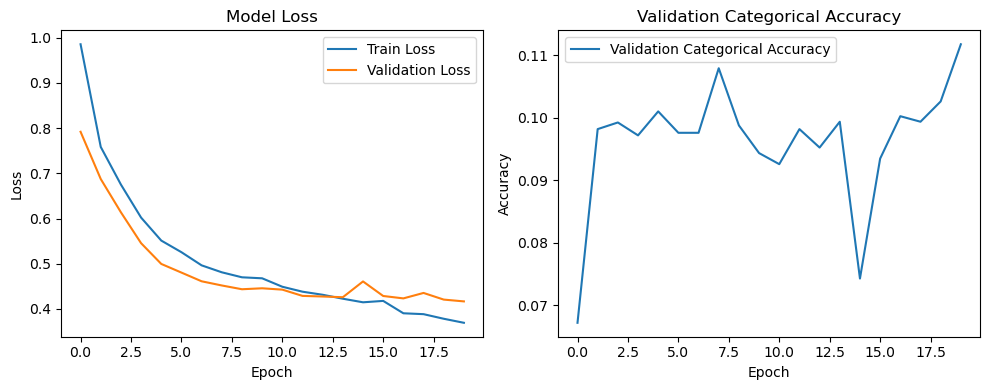

In [383]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation categorical accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracy_history, label='Validation Categorical Accuracy')
plt.title('Validation Categorical Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [386]:
from src.evaluation import f1_score_overall

# TODO: Evaluate the model with a F1 Score

###

## Task 5.5: Discussion and comparison

* Compare the performances of our two models in your own words

* Why do you think it improved?

* Can you think of any other social context to further improve our model?

**TODO: Write your thoughts here**


* The results visibly improved, Here, however, we could've stopped at roughly epoch no. 12, because after that there's clearly some overfitting going on, based on the graph. So the main thing that improved is the model's performance. 
* Theoretically it should have improved because of the provided context. Additionally it would be good to add something like whether the user was joking, recent political events that might've influenced their opinion, etc.


* The following applied to the previous version of this .ipynb file, where I made a mistake in the getitem for the CustomDatasetNew, switching the y and h's positions, which lead to the results being worse: [Based purely on the output of the last cell -- I did something entirely wrong because not only did the performance did not improve, but it got actively worse. My best guess is that it has to do with the dimensionality of the hate scores.]


## References

[1] Festinger, L., Pepitone, A. and Newcomb, T. (1952) *Some Consequences of De-Individuation in a Group.* Journal of Abnormal and Social Psychology, 47, 382-389.
<br>[2] Waseem, Z., & Hovy, D. (2016). *Hateful symbols or hateful people? Predictive features for hate speech detection on Twitter.* In Proceedings of the naacl student research workshop (pp. 88-93).
<br>[3] https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
<br>[4] https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
<br>[5] https://pytorch.org/docs/stable/nn.html
<br>[6] Jahn, L. (2020). *Leveraging Social Network Data for Hate Speech Detection.* Master
Thesis, Technical University of Munich, Department of Informatics.